In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

In [6]:
# reflect the tables

Base.prepare(engine, reflect=True) 

In [7]:
# View all of the classes that automap found

Base.classes.keys() 

['measurement', 'station']

In [8]:
# Save references to each table

Measurement = Base.classes.measurement

Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB

session = Session(engine) 

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

first_row_M = session.query(Measurement).first()
first_row_M.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x236076ff5e0>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
first_row_S = session.query(Station).first()
first_row_S.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x236076d33d0>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

In [12]:
dates = session.query(Measurement.date)

# print(dates.all())

max_date = max(dates)[0]

print(f"MAX: {max(dates)[0]}")
print(f"MIN: {min(dates)[0]}")

MAX: 2017-08-23
MIN: 2010-01-01


In [13]:
max_date_parts = max(dates)[0].split("-")

print(max_date_parts)

max_yr, max_mn, max_dy = int(max_date_parts[0]), int(max_date_parts[1]), int(max_date_parts[2])

print(max_yr, max_mn, max_dy)

['2017', '08', '23']
2017 8 23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

from dateutil.relativedelta import relativedelta                 # thx to Tom! 

query_date = dt.date(max_yr, max_mn, max_dy) - relativedelta(months=12)

print(query_date)

# Calculate the date one year from the last date in data set.

plus_one_yr = dt.date(max_yr, max_mn, max_dy) + relativedelta(years=1)

print(plus_one_yr)

2016-08-23
2018-08-23


In [17]:
# Perform a query to retrieve the data and precipitation scores

precip = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= query_date).all()

# print(precip)

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(data=precip)

df = df.set_index(keys=df["date"], drop=True)

df = df.drop(["date"], axis=1)

# Sort the dataframe by date

df = df.sort_index(axis=0)

df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<AxesSubplot:xlabel='Date', ylabel='Inches'>

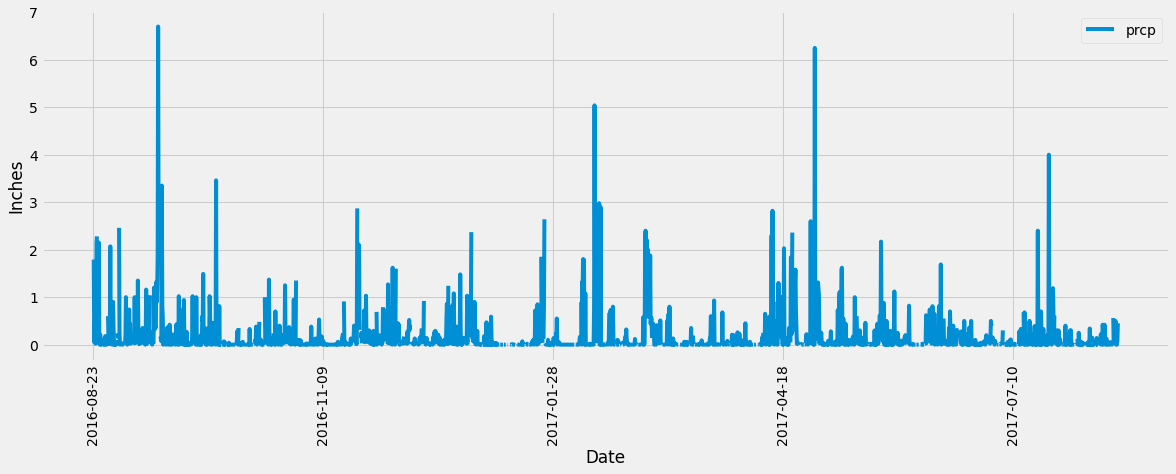

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(figsize=(18, 6), rot=90, xlabel="Date", ylabel="Inches")

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number stations in the dataset

stations1 = session.query(Station.station).distinct().count()
print(stations1)

9


In [24]:
stations2 = session.query(Measurement.station).distinct().count()
print(stations2)

9


In [25]:
station_lst = session.query(Station.station).distinct().all()
print(station_lst)

new_lst = []

for station in station_lst:
    new_lst.append(station[0])
    
print(new_lst)

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]
['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128']


In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

newer_lst = []

for station in new_lst:
    cnt = session.query(Measurement.station).filter(Measurement.station == station).count()
    print(f"Station: {station}")
    print(f"Row Count: {cnt}\n")
    newer_lst.append((cnt, station))
    
newer_lst = sorted(newer_lst, reverse=True)
print(f"\n\n{newer_lst}")
    
    

Station: USC00519397
Row Count: 2724

Station: USC00513117
Row Count: 2709

Station: USC00514830
Row Count: 2202

Station: USC00517948
Row Count: 1372

Station: USC00518838
Row Count: 511

Station: USC00519523
Row Count: 2669

Station: USC00519281
Row Count: 2772

Station: USC00511918
Row Count: 1979

Station: USC00516128
Row Count: 2612



[(2772, 'USC00519281'), (2724, 'USC00519397'), (2709, 'USC00513117'), (2669, 'USC00519523'), (2612, 'USC00516128'), (2202, 'USC00514830'), (1979, 'USC00511918'), (1372, 'USC00517948'), (511, 'USC00518838')]


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = newer_lst[0][1]

print(most_active_station)


sel = [Measurement.tobs,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)
       ]


results = session.query(*sel).filter(Measurement.station == most_active_station).first()

print(results)            



USC00519281
(85.0, 54.0, 85.0, 71.66378066378067)


In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

dates = session.query(Measurement.date).filter(Measurement.station == most_active_station)

max_date = max(dates)[0].split("-")
print(max_date)

yr, mn, dy = int(max_date[0]), int(max_date[1]), int(max_date[2])


print(yr, mn, dy)

query_date = dt.date(yr, mn, dy) - relativedelta(months=12)

print(query_date)

['2017', '08', '18']
2017 8 18
2016-08-18


<Figure size 576x432 with 0 Axes>

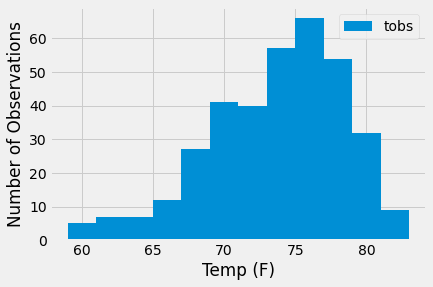

<Figure size 576x432 with 0 Axes>

In [33]:
sel = [Measurement.date, 
       Measurement.tobs
          ]


results = session.query(*sel).filter(Measurement.station == most_active_station).filter(Measurement.date >= query_date).all()

df = pd.DataFrame(data=results)

df = df.set_index(keys="date")

df.plot.hist(bins=12)
plt.xlabel("Temp (F)")
plt.ylabel("Number of Observations")
plt.figure(figsize=(8,6))

# Close session

In [31]:
# Close Session
session.close()